In [30]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy.orm import aliased
from sqlalchemy import desc
import datetime as dt
from datetime import datetime, time

In [31]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [32]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [33]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [34]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [35]:
#Get the table information
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [36]:
# Create our session (link) from Python to the DB
session = Session(engine)

Step 1 - Climate Analysis and Exploration

In [37]:
def year_ago(date_str):
    new_date = datetime.strftime((datetime.strptime(date_str,'%Y-%m-%d') - dt.timedelta(days=365)).date(),'%Y-%m-%d')
    return new_date

In [38]:
year_ago('2020-02-10')

'2019-02-10'

In [39]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
date_prcp_query = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >='2016-08-09', Measurement.date <='2017-08-09').\
order_by(Measurement.date).statement

In [40]:
# Save the query results as a Pandas DataFrame and set the index to the date column
date_prcp_df = pd.read_sql(date_prcp_query, engine).dropna()
date_prcp_df.head(5)

,date,prcp
0,2016-08-09,0.00
1,2016-08-09,0.00
2,2016-08-09,0.00
4,2016-08-09,0.01
5,2016-08-09,0.02


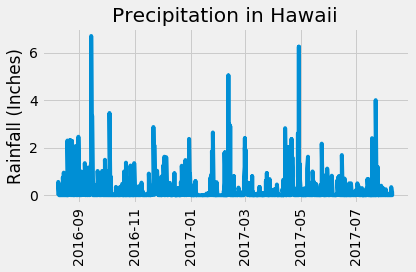

In [43]:
#Use Pandas Plotting with Matplotlib to plot the data 
date_prcp_df['date']  = pd.to_datetime(date_prcp_df['date'])
plt.plot(date_prcp_df['date'], date_prcp_df['prcp'])
plt.title("Precipitation in Hawaii")
plt.xlabel('')
plt.ylabel('Rainfall (Inches)')
plt.xticks(rotation='90')
plt.tight_layout()
plt.savefig('rainfall_chart.png')
plt.show()


In [44]:
date_prcp_df.describe()

,prcp
count,2055.000000
mean,0.180511
std,0.464437
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


Station Analysis

In [45]:
#How many stations are available in this dataset
station_boolean = session.query(Measurement.station).distinct().count()== session.query(Station.station).distinct().count()
if station_boolean:
    num_station = session.query(Measurement.station).distinct().count()
    print(f'The number of stations = {num_station}')
else:
    print('')

The number of stations = 9


In [46]:
#List the stations and the observation counts in descending order.
desc_observ = engine.execute('select station, count(station) from measurement group by station order by count(station) desc').fetchall()
desc_observ

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [47]:
#station has the highest number of observations
station_id = desc_observ[0][0]
station_name = session.query(Station.name).filter(Station.station==desc_observ[0][0]).all()
print(f'The highest number of observations come from {station_name[0][0]}')

The highest number of observations come from WAIHEE 837.5, HI US


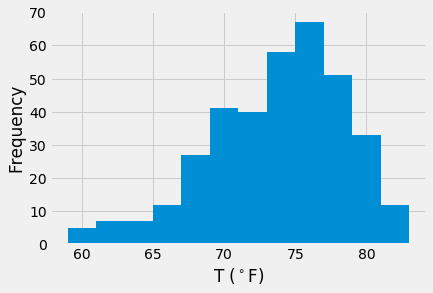

In [48]:
#Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_query = session.query(Measurement.tobs, Measurement.station).\
filter(Measurement.date >='2016-08-09', Measurement.date <='2017-08-09').\
filter(Measurement.station==station_id).\
order_by(Measurement.date).statement 

tobs_df = pd.read_sql(tobs_query, engine).dropna()
tobs_df.head(5)

x = tobs_df['tobs']

plt.hist(x, bins=12)
plt.xlabel(r'T ($^\circ$F)')
plt.ylabel('Frequency')
plt.savefig('climate_histoG.png')
plt.show()

In [49]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2017-07-19', '2017-07-29'))

[(72.0, 78.61971830985915, 84.0)]


In [50]:

# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = year_ago('2017-07-19')
trip_end_date = year_ago('2017-07-29')
trip_end_date

'2016-07-29'

In [51]:
trip_start_date

'2016-07-19'

In [52]:
prev_year = calc_temps(trip_start_date, trip_end_date)
tmin = prev_year[0][0]
tavg = round(prev_year[0][1],2)
tmax = prev_year[0][2]
tdif = tmax-tmin
print(f"The minimum temperature during your vacation the previous year was {tmin},\
 maximum {tmax} and average {tavg}. That's a difference of {tdif} degrees!")

The minimum temperature during your vacation the previous year was 73.0, maximum 83.0 and average 78.31. That's a difference of 10.0 degrees!


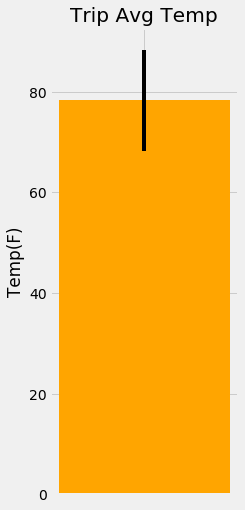

In [53]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(3,8)) 
plt.bar(x='',height=tavg, yerr=tdif, color='orange')
plt.ylabel('Temp(F)')
plt.title('Trip Avg Temp')
plt.savefig('trip_temp.png')
plt.show()

In [54]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [func.sum(Measurement.prcp).label('precip'),
       Station.station,
      Station.name,
      Station.latitude,
      Station.longitude,
      Station.elevation]
precip = session.query(*sel).\
filter(Measurement.station==Station.station).\
filter(func.strftime("%Y-%m-%d", Measurement.date) > trip_start_date).\
filter(func.strftime("%Y-%m-%d", Measurement.date) < trip_end_date).\
group_by(Station.station).\
order_by(desc('precip')).all()

rainfall_PWS = pd.DataFrame(precip)
rainfall_PWS

,precip,station,name,latitude,longitude,elevation
0,11.28,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
1,8.25,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
2,8.08,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,4.39,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
4,3.27,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
5,0.05,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
6,0.01,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


Optional Challenge Assignment

In [55]:
# Create a query that will calculate the daily normals 
# (The averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [56]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-07-19'
end_date = '2017-07-29'
# Use the start and end date to create a range of dates
# Strip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_len = (datetime.strptime(end_date,'%Y-%m-%d') - datetime.strptime(start_date,'%Y-%m-%d')).days + 1
trip_data = []
trip_dates = []
for date in range(0,trip_len):
    day = (datetime.strptime(start_date,'%Y-%m-%d') + dt.timedelta(days=date))
    trip_dates.append(datetime.strftime(day,'%m-%d'))
    trip_data.append(daily_normals(datetime.strftime(day,'%m-%d'))[0])

In [57]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
temp_df = pd.DataFrame(trip_data, columns=['Min Temp','Avg Temp','Max Temp'])
temp_df['Date'] = trip_dates
temp_df

,Min Temp,Avg Temp,Max Temp,Date
0,68.0,75.890909,83.0,07-19
1,69.0,75.462963,82.0,07-20
2,69.0,76.924528,83.0,07-21
3,69.0,75.788462,81.0,07-22
4,70.0,76.203704,84.0,07-23
5,69.0,76.555556,81.0,07-24
6,67.0,76.890909,84.0,07-25
7,71.0,76.442308,86.0,07-26
8,68.0,76.581818,83.0,07-27
9,69.0,76.464286,82.0,07-28


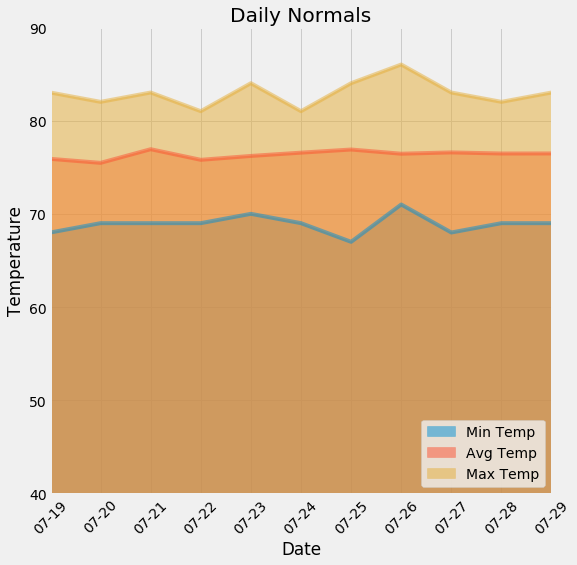

In [58]:
# Plot the daily normals as an area plot with `stacked=False`
ax = temp_df.plot(kind='area',stacked=False,figsize=(8,8),ylim=(40,90))
ax.set_xticks(range(len(temp_df)))
ax.set_xticklabels(temp_df['Date'], rotation=45)
plt.ylabel('Temperature')
plt.xlabel('Date')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
plt.legend(loc='lower right')
plt.title(f"Daily Normals")
plt.savefig('daily_normals.png')